<div style="text-align: center; color: red;">
    <h1>Projet de classification d’images d’hématies</h1>
</div>

<div style="text-align: center;">
    <h2 style="color: blue;">Membres du Groupe</h2>
    <ul style="list-style-type: none; padding: 0;">
        <li style="color: green; font-size: 18px;">Membre 1: KOURSI Nora</li>
        <li style="color: green; font-size: 18px;">Membre 2: BEN MOUH Kawtar</li>
    </ul>
</div>


# Manipulation de la Donnée

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


# Vérification de l'utilisation du GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Chargement des données

In [2]:
data_dir = 'malaria_hematie_dataset/'

def load_images_labels(data_dir):
    images = []
    labels = []
    for label in ['Parasitized', 'Uninfected']:
        for file in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, file)
            img = Image.open(img_path)
            img = img.resize((64, 64)) 
            img = np.array(img)
            if img.shape == (64, 64, 3): 
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_labels(data_dir)

## Normalisation des images

In [3]:
images = images / 255.0

## Encodage des labels

In [4]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

## Séparation en jeux d'entraînement et de test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

## Augmentation des Données

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

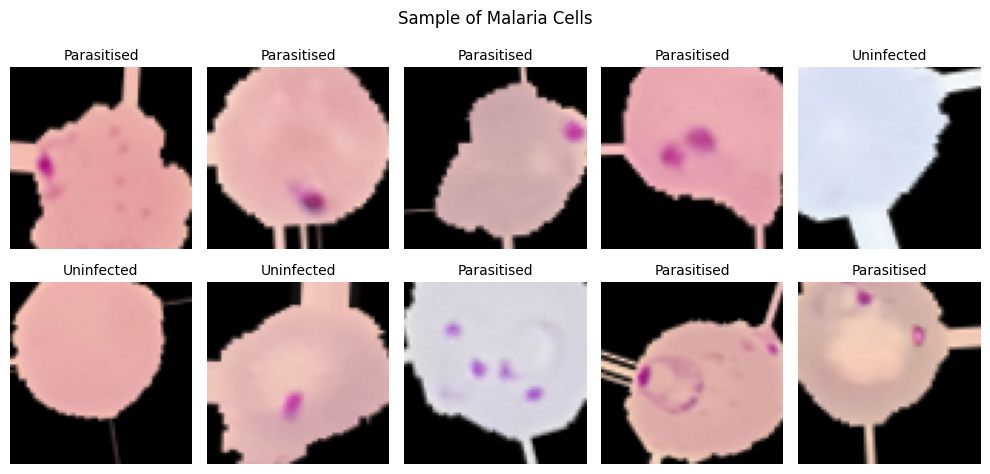

In [8]:
# Exemple d'augmentation de données
example_generator = datagen.flow(X_train[:10], y_train[:10], batch_size=1)
fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    batch = next(example_generator)
    image = batch[0][0]
    if image.max() <= 1.0:  # Vérifiez si l'image est normalisée
        image = (image * 255).astype('uint8')  # Ramenez à l'échelle 0-255
    ax.imshow(image)
    ax.axis("off")
    ax.set_title("Uninfected" if batch[1][0] == 1 else "Parasitised", fontsize=10)

fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()
plt.show()


# Entraînement de 3 Modèles

## Implémentation de 2 Callbacks

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

## Implémentation des Modèles

In [10]:
def create_model_scratch():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Dropout(0.2),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model_scratch()

C:\Users\norak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

**Fine-tuning du VGG16**

In [11]:
def create_model_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model_vgg16()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Fine-tuning du ResNet50**

In [12]:

def create_model_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model_resnet50()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 32, 32, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Entraînement des Modèles

In [14]:
# Entraînement des modèles
batch_size = 32
epochs = 10

# Modèle from scratch
model_scratch = create_model_scratch()
history_scratch = model_scratch.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                    validation_data=(X_test, y_test),
                                    epochs=epochs, callbacks=[early_stopping, reduce_lr])
model_scratch.save_weights('model_scratch_weights.h5')

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 145ms/step - accuracy: 0.9228 - loss: 0.2307 - val_accuracy: 0.9432 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9256 - loss: 0.2178 - val_accuracy: 0.9499 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 96s 138ms/step - accuracy: 0.9235 - loss: 0.2214 - val_accuracy: 0.9463 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 97s 141ms/step - accuracy: 0.9244 - loss: 0.2217 - val_accuracy: 0.9494 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 94s 135ms/step - accuracy: 0.9233 - loss: 0.2284 - val_accuracy: 0.9568 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 93s 134ms/step - accuracy: 0.9281 - loss: 0.2113 - val_accuracy: 0.9563 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 91s 132ms/step - accuracy: 0.

In [17]:
# Modèle VGG16
model_vgg16 = create_model_vgg16()
history_vgg16 = model_vgg16.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                validation_data=(X_test, y_test),
                                epochs=epochs, callbacks=[early_stopping, reduce_lr])
model_vgg16.save_weights('model_vgg16_weights.h5')

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 490s 693ms/step - accuracy: 0.7931 - loss: 0.4355 - val_accuracy: 0.9082 - val_loss: 0.2345 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 528s 765ms/step - accuracy: 0.8635 - loss: 0.3254 - val_accuracy: 0.9078 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4697s 7s/step - accuracy: 0.8711 - loss: 0.3206 - val_accuracy: 0.9136 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 434s 629ms/step - accuracy: 0.8755 - loss: 0.3103 - val_accuracy: 0.9160 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 433s 628ms/step - accuracy: 0.8761 - loss: 0.3070 - val_accuracy: 0.9198 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 416s 604ms/step - accuracy: 0.8820 - loss: 0.3006 - val_accuracy: 0.9222 - val_loss: 0.2006 - learning_rate: 0.0010
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 442s 641ms/step - accuracy

In [18]:
# Modèle ResNet50
model_resnet50 = create_model_resnet50()
history_resnet50 = model_resnet50.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                      validation_data=(X_test, y_test),
                                      epochs=epochs, callbacks=[early_stopping, reduce_lr])
model_resnet50.save_weights('model_resnet50_weights.h5')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 32, 32, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 322s 431ms/step - accuracy: 0.5533 - loss: 0.6920 - val_accuracy: 0.6261 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 283s 410ms/step - accuracy: 0.5980 - loss: 0.6637 - val_accuracy: 0.6185 - val_loss: 0.6571 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 267s 387ms/step - accuracy: 0.6101 - loss: 0.6580 - val_accuracy: 0.6408 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 288s 418ms/step - accuracy: 0.6240 - loss: 0.6534 - val_accuracy: 0.6272 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 7143s 10s/step - accuracy: 0.6244 - loss: 0.6518 - val_accuracy: 0.6524 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 37082s 54s/step - accuracy: 0.6233 - loss: 0.6510 - val_accuracy: 0.6551 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 305s 441ms/step - accurac

ValueError: The filename must end in `.weights.h5`. Received: filepath=model_resnet50_weights.h5

## Évaluation des Modèles

In [19]:
# Fonction pour obtenir les prédictions binaires
def get_predictions(model, X_test):
    y_pred = model.predict(X_test)
    return (y_pred > 0.5).astype('int32')

# Matrices de confusion pour chaque modèle
conf_matrix_scratch = confusion_matrix(y_test, get_predictions(model_scratch, X_test))
conf_matrix_vgg16 = confusion_matrix(y_test, get_predictions(model_vgg16, X_test))
conf_matrix_resnet50 = confusion_matrix(y_test, get_predictions(model_resnet50, X_test))

print("Confusion Matrix for Scratch Model:\n", conf_matrix_scratch)
print("Confusion Matrix for VGG16 Model:\n", conf_matrix_vgg16)
print("Confusion Matrix for ResNet50 Model:\n", conf_matrix_resnet50)


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 398ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step
Confusion Matrix for Scratch Model:
 [[2635  162]
 [  79 2636]]
Confusion Matrix for VGG16 Model:
 [[2501  296]
 [ 210 2505]]
Confusion Matrix for ResNet50 Model:
 [[1208 1589]
 [ 472 2243]]


In [20]:
# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Calcul des métriques pour chaque modèle
accuracy_scratch, precision_scratch, recall_scratch, f1_scratch = calculate_metrics(y_test, get_predictions(model_scratch, X_test))
accuracy_vgg16, precision_vgg16, recall_vgg16, f1_vgg16 = calculate_metrics(y_test, get_predictions(model_vgg16, X_test))
accuracy_resnet50, precision_resnet50, recall_resnet50, f1_resnet50 = calculate_metrics(y_test, get_predictions(model_resnet50, X_test))

print(f"Scratch Model - Accuracy: {accuracy_scratch:.4f}, Precision: {precision_scratch:.4f}, Recall: {recall_scratch:.4f}, F1 Score: {f1_scratch:.4f}")
print(f"VGG16 Model - Accuracy: {accuracy_vgg16:.4f}, Precision: {precision_vgg16:.4f}, Recall: {recall_vgg16:.4f}, F1 Score: {f1_vgg16:.4f}")
print(f"ResNet50 Model - Accuracy: {accuracy_resnet50:.4f}, Precision: {precision_resnet50:.4f}, Recall: {recall_resnet50:.4f}, F1 Score: {f1_resnet50:.4f}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step
Scratch Model - Accuracy: 0.9563, Precision: 0.9421, Recall: 0.9709, F1 Score: 0.9563
VGG16 Model - Accuracy: 0.9082, Precision: 0.8943, Recall: 0.9227, F1 Score: 0.9083
ResNet50 Model - Accuracy: 0.6261, Precision: 0.5853, Recall: 0.8262, F1 Score: 0.6852


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 107s 618ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step


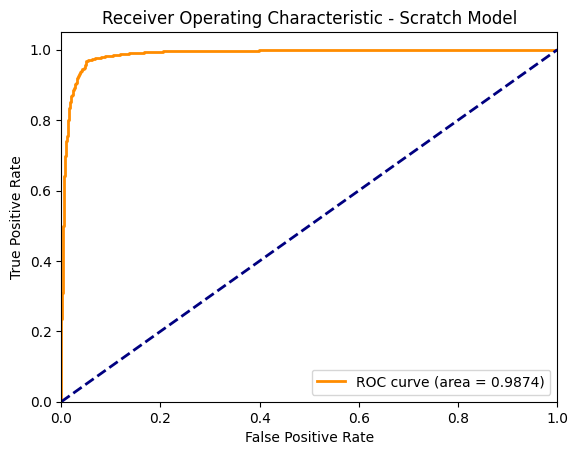

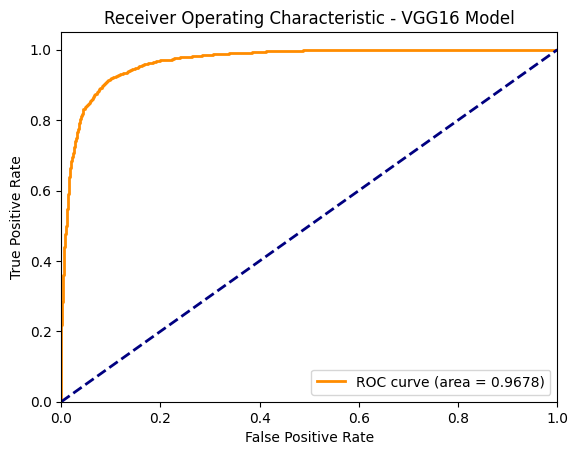

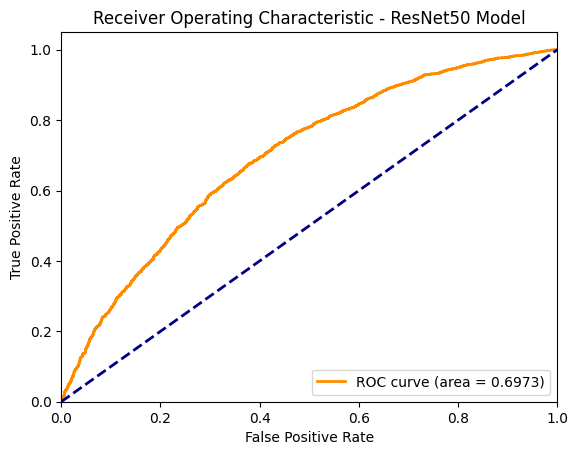

In [21]:
# Fonction pour calculer la courbe ROC et l'AUC
def calculate_roc_auc(model, X_test, y_test):
    y_pred = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Calcul de la courbe ROC et de l'AUC pour chaque modèle
fpr_scratch, tpr_scratch, auc_scratch = calculate_roc_auc(model_scratch, X_test, y_test)
fpr_vgg16, tpr_vgg16, auc_vgg16 = calculate_roc_auc(model_vgg16, X_test, y_test)
fpr_resnet50, tpr_resnet50, auc_resnet50 = calculate_roc_auc(model_resnet50, X_test, y_test)

# Affichage des courbes ROC
def plot_roc(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(fpr_scratch, tpr_scratch, auc_scratch, 'Scratch Model')
plot_roc(fpr_vgg16, tpr_vgg16, auc_vgg16, 'VGG16 Model')
plot_roc(fpr_resnet50, tpr_resnet50, auc_resnet50, 'ResNet50 Model')
